In [3]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import csv
import re
from functools import reduce

plt.style.use("seaborn")

# Produce data

To retrieve the raw data, the Python static code analyzer [Lizard](https://github.com/terryyin/lizard) was used.

```
# the following command produces a csv-file with all the necessary data for analysis
# stand in the root folder of inda student repos
# -o specifies output name
# --exclude excludes all files containing 'Test'
# --csv specifies format

lizard -o inda-repos-students.csv --exclude "^.*Test.*$" --csv -l java
```

# Process data
Next step is to process the generated data. The CSV-file has an verbose output string that contains all necessary information which can be retrieved by regex.

In [4]:
# specify input and output paths
source = "data/lizard/inda-repos-students.csv"
destination = "data/processed/inda-repos-students.csv"

# the source (Lizard) csv-header and the destination header
source_headers = ["NLOC", "CCN", "token", "PARAM", "length", "verbose", "input", "class::method", "class::method(args)", "start line", "end line"]
destination_headers = ["NLOC", "CCN", "token", "PARAM", "length", "TA", "student", "task", "class", "method"]

# necessary regex is stored in a dictionary
regex = {
    "task": "((?<=task-)[0-9]+)", # capture a number preceded by 'task-'
    "class": "^[A-Za-z0-9]*", # capture any letter or number from start to end of string
    "TA": "(?<=repos\/)[A-Za-z]+(?=\/)", # capture any string preceded by 'repos/' and ending with a '/'
    "student": "((?<=\/)([a-zA-Z0-9]+)(?=-task))", # capture any string preceded by '/' and ending with '-task'
    "method": "((?<=::).*(?=\())" # nasty
}

Next we process the data by extracting the right information from the Lizard file. At the end there's a report of the amount of faulty lines.

TODO: ta reda på vad som faktiskt orsakar `AttributeError`.

In [5]:
rows = []
attribute_errors = 0
with open(source, newline='') as csvfile:
    reader = csv.DictReader(csvfile, fieldnames=source_headers)
    for row in reader:
        try:
            ta = re.search(regex["TA"], row['verbose']).group(0)
            student = re.search(regex["student"], row['verbose']).group(0)
            task = int(re.search(regex["task"], row['verbose']).group(0))
            clss = re.search(regex["class"], row['class::method']).group(0)
            method = re.search(regex["method"], row['class::method(args)']).group(0)
        except AttributeError:
            # eftersom lösningar som ej kompilerar pajar regexen är detta nödvändigt
            # Sätter till NaN för att kunna filtrera ut i Pandas
            attribute_errors = attribute_errors + 1 # keep track of amount of faulty lines
            ta = "NaN"
            student = "NaN"
            task = "NaN"
            clss = "NaN"
            method = "NaN"
        new_row = { # if we reach here all is well
                    "NLOC": row['NLOC'], 
                    "CCN": row['CCN'], 
                    "token": row['token'], 
                    "PARAM": row['PARAM'], 
                    "length": row['length'],
                    "TA": ta,
                    "student": student, 
                    "task": task, 
                    "class": clss, 
                    "method": method
                    }
        rows.append(new_row)

with open(destination, 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=destination_headers)
    writer.writeheader()
    writer.writerows(rows)

print(f"Done parsing a total of {len(rows)} rows, with {attribute_errors} faulty lines! That's a felmariginal of {attribute_errors/len(rows)}")


Done parsing a total of 12324 rows, with 23 faulty lines! That's a felmariginal of 0.001866277182732879


# Analyze inda code templates

Here the empty code templates are measured.

In [50]:
# Find Lines of Code for the code templates 
# Note that task 2-4 are empty, yet students recieve a Java template from Objects First

df_templates = pd.read_csv("data/processed/inda-templates-sorted.csv")
df_templates = df_templates.groupby(["task"])["NLOC"].sum().astype(float).reset_index()

# as there's no provided code skeleton for task 2-4, 10 and 17 these has to be appended
missing_tasks =  ({
            "task": [1, 2, 3, 4, 10, 17],
            "NLOC": [0, 0, 0, 0, 0, 0]
            })

# the missing tasks are concatenated, and then the dataframe is reindexed with task as index
df_templates = pd.concat([df_templates, pd.DataFrame(missing_tasks)], ignore_index = True, axis = 0)
df_templates = df_templates.sort_values(by=["task"]).reset_index(drop = True)
#df_templates = df_templates.set_index(["task"])
df_templates.head()


,task,NLOC
0,1,0.0
1,2,0.0
2,3,0.0
3,4,0.0
4,5,344.0


In [35]:
df_students = pd.read_csv("data/processed/inda-repos-students.csv")
df_students = df_students.groupby(["task", "student"])["NLOC"].sum().reset_index().astype({"task": int})
df_students = df_students.set_index(["task"])
df_students.head()

,student,NLOC
task,,
1,falkborn,3
2,alflil,16
2,birgerk,72
2,dlindbo,27
2,falkborn,66


/tmp/ipykernel_420/2413529276.py:8: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ro" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(df_templates["NLOC"], 'ro', label = "Code template", marker =  "|", markeredgewidth = 25, markersize = 1.5, alpha = 0.6)


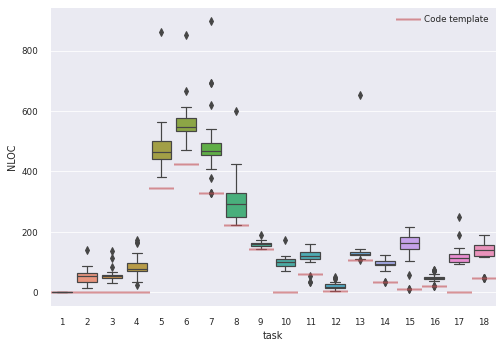

In [76]:
# Plot lines of code for students submissions and code template
sn.set_theme()
sn.set_context("paper")
df =  df_students.groupby(["task", "student"])["NLOC"].sum().reset_index()
df["task"] = df["task"].astype("int")
#df = df.set_index(df["task"]).drop(columns = ["task"])
ax = sn.boxplot(x="task", y = "NLOC", data = df)
plt.plot(df_templates["NLOC"], 'ro', label = "Code template", marker =  "|", markeredgewidth = 25, markersize = 1.5, alpha = 0.6)
plt.legend()

/tmp/ipykernel_420/2420205968.py:2: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ro" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(df_templates["NLOC"], 'ro', label = "Code template", marker =  "|", markeredgewidth = 17, markersize = 4)


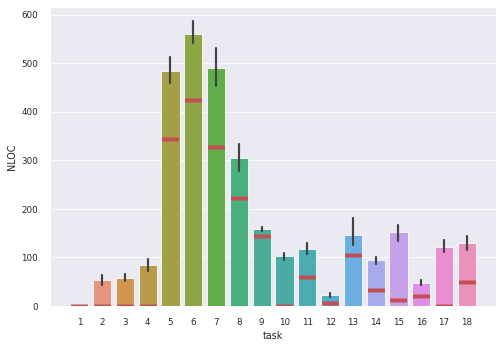

In [84]:
ax = sn.barplot(x="task", y="NLOC", data=df)
plt.plot(df_templates["NLOC"], 'ro', label = "Code template", marker =  "|", markeredgewidth = 17, markersize = 4)

In [95]:
#df = pd.read_csv("inda_data.csv", sep=";")
df = pd.read_csv("data/inda-data-test-by-ta.csv")

df.head()

,NLOC,CCN,token,PARAM,length,TA,student,task,class,method
0,4,1,24,0,4,linus,briano,7,DrawDemo,DrawDemo
1,5,1,32,0,6,linus,briano,7,DrawDemo,drawSquare
2,5,1,32,0,7,linus,briano,7,DrawDemo,drawTriangle
3,8,2,55,0,9,linus,briano,7,DrawDemo,drawWheel
4,5,1,32,0,6,linus,briano,7,DrawDemo,drawPentagon


# Compose data

In [145]:
# Group by and Summarize
#group = df.groupby(["TA", "student", "task", "class", "method"], as_index = False).sum()
group = df.groupby(["TA", "student", "task", "class", "method"]).sum()
#group[group.task == 2]["class"]
# jag  vill dela varje suma(NLOC per klass) med antalet metoder i den klassen
group.agg("min")


NLOC      1
CCN       1
token     5
PARAM     0
length    1
dtype: int64

# Make plots

In [28]:
for ta, rows in df.groupby("TA"):
    sn.relplot(data=rows, x="Operation Structuring", y="Intrinsic operation complexity", hue="task")
    plt.title(ta)

ValueError: Could not interpret value `Operation Structuring` for parameter `x`